# Evaluate
https://docs.opencv.org/3.4.1/d1/d89/tutorial_py_orb.html

In [1]:
# init prerequisites
%reload_ext autoreload
%autoreload 2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os, re, math, time, random, yaml
from pprint import pprint

import tensorflow as tf
from tensorflow import keras

import util
from util import print_warn, horline

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print("OpenCV {}".format(cv.__version__))
print("Numpy {}".format(np.__version__))
print("Tensorflow {}".format(tf.__version__))

OpenCV 3.4.1
Numpy 1.16.2
Tensorflow 1.13.1


In [2]:
#config_modelname="sigmoid-190509"
#config_modelname="tanh-190509"
config_modelname="relu-190509"

config = dict(
    inputfolder="./input/classes_r2",
    outputfolder="./output/ml",
    model="./output/{}.h5".format(config_modelname),
    model_map="./output/{}.map".format(config_modelname),
    class_ignore={ # if input data has less labels, tell me which classes can be ignored
        9: [10],  # predicted 10 is also fine for labeled 9
        11: [10], # predicted 10 is also fine for labeled 11
        6: [7],
        8: [7],
        3: [4],
        5: [4],
    }
)
pprint(config)

{'class_ignore': {3: [4], 5: [4], 6: [7], 8: [7], 9: [10], 11: [10]},
 'inputfolder': './input/classes_r2',
 'model': './output/relu-190509.h5',
 'model_map': './output/relu-190509.map',
 'outputfolder': './output/ml'}


In [3]:
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.set_session(sess)

print("loading model")
model = keras.models.load_model(config["model"])
model.summary()

import yaml
with open(config["model_map"], 'r') as f:
    model_labels = yaml.load(f, Loader=yaml.FullLoader)
pprint(model_labels)

print("done.")

loading model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2560256   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3

In [15]:
# output helper
def result_to_color(result, index, predicted, labeled):
    if labeled in config["class_ignore"] and index in config["class_ignore"][labeled]:
        # green
        color = (32,(0,255,0))
    elif labeled == index:
        # green
        color = (32,(0,255,0))
    elif labeled > len(result):
        # image class was not in training data
        # magenta
        color = (35,(64,64,64))
    else:
        if result[index] > 1e-4:
            if index == predicted:
                # red
                color = (31,(0,0,255))
            else:
                # yellow
                color = (33,(0,255,255))
        else:
            # black
            color = (30,(128,0,0))
    return color

def pprint_result(result, label=None, img=None, count_hit=None, count_miss=None):
    max = np.argmax(result)
    
    put = result[0]
    color = result_to_color(result, 0, max, label)
    str = "[\x1b[{}m{:.4f}".format(color[0], put)
    if img is not None: 
        width = (img.shape[1] - 20) / len(result)
        cv.putText(img, "{:.3f}".format(put), (10,20), font, 0.7, color[1], 2, cv.LINE_AA)

    for j in range(1, len(result)):
        put = result[j]
        color = result_to_color(result, j, max, label)
        str += " \x1b[{}m{:.4f}".format(color[0], put)
        if img is not None: 
            cv.putText(img, "{:.3f}".format(put), (int(10+width*j),20), font, 0.7, color[1], 2, cv.LINE_AA)
    
    if label in label_name:
        str += "\x1b[0m] {} ({}<>{})".format(label_name[label][1], label, max)
    else:
        str += "\x1b[0m] unknown ({}<>{})".format(label, max)
    print(str)
    return str

In [4]:
# collect input files
paths, labels, label_name = util.recursive_collect(config["inputfolder"], model_labels=model_labels)
input_images = []
prev = None

pprint(label_name)

# sort data by image index
input_data = list(zip(paths, labels))
input_data = sorted(input_data, key = lambda x: x[0].split("\\")[-1])
paths, labels = zip(*input_data)

font = cv.FONT_HERSHEY_SIMPLEX

# for evaluation of performance
confusion_labels = list()
confusion_predictions = list()
prediction_errors = list()
count_hit = 0
count_miss = 0

# speedrun
wait_normal = 1
wait_error = 1
wait_on_error = True

cv.destroyAllWindows()
out = None
for i, path, label in zip(range(len(paths)), paths, labels):
    rate = count_hit / (count_hit + count_miss) if (count_hit + count_miss) > 0 else 1.0
    print("{} {:.3f} {}, {}".format(i, rate, path, label))
    start_time = time.perf_counter()

    # read input image
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    #img = cv.medianBlur(img, 29)

    mean, dev = cv.meanStdDev(img)
    img_small = cv.resize((img - mean)/dev, (100,100))
    img_small = np.expand_dims(img_small, axis=2)
    img_small = np.expand_dims(img_small, axis=0)
    predictions = model.predict(img_small)
    predicted = np.argmax(predictions)
    confusion_labels.append(label)
    confusion_predictions.append(predicted)
    wait = wait_normal
    
    # convert to colored image for drawing on image
    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    result_str = pprint_result(predictions[0], label, img)
    
    # put information about predicted and labeled class into image
    is_fine = label in config["class_ignore"] and predicted in config["class_ignore"][label]
    if predicted != label and not is_fine:
        cv.putText(img, label_name[np.argmax(predictions)][1], (10,img.shape[0] - 20), font, 0.8, (0,0,255), 2, cv.LINE_AA)
        cv.putText(img, label_name[label][1], (int(img.shape[1]/2 + 10),img.shape[0] - 20), font, 0.8, (0,255,0), 2, cv.LINE_AA)
        prediction_errors.append((path, label, predicted))
        if wait_on_error: wait = wait_error
        count_miss += 1
    else:
        cv.putText(img, label_name[np.argmax(predictions)][1], (10,img.shape[0] - 20), font, 0.8, (0,0,0), 2, cv.LINE_AA)
        count_hit += 1
    
    if out is None:
        outh,outw,_ = img.shape
        out = cv.VideoWriter(os.path.join(config["outputfolder"], "{}.avi".format(config_modelname)), cv.VideoWriter_fourcc(*'MJPG'), 10, (outw,outh))
    out.write(img)
    
    # show images and wait
    cv.imshow('result', img); plt.show()
    k = cv.waitKey(wait) & 0xff
    if k == 27:
        if out is not None:
            out.release()
        break
    elif k == ord('s'):
        if not os.path.isdir(config["outputfolder"]):
            os.mkdir(config["outputfolder"])
        cv.imwrite(os.path.join(config["outputfolder"], os.path.basename(path)), img)


cv.destroyAllWindows()

{0: (9, '1_home'),
 1: (128, '2.1_moving'),
 2: (113, '2.2_moving_wafer'),
 3: (188, '3.1_cassette_location_empty'),
 4: (198, '3.2_cassette_location_unknown'),
 5: (163, '3.3_cassette_location_wafer'),
 6: (716, '4.1_processchamber_empty'),
 7: (206, '4.2_processchamber_unknown'),
 8: (141, '4.3_processchamber_wafer'),
 9: (208, '5.1_cooling_station_wafer'),
 10: (149, '5.2_cooling_station_unknown'),
 11: (221, '5.3_cooling_station_empty'),
 20: (120, '0_idle')}
0 1.000 ./input/classes_r2\0_idle\gray_88201.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
1 0.000 ./input/classes_r2\0_idle\gray_88202.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
2 0.000 ./input/classes_r2\0_idle\gray_88203.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
3 0.000 ./input/classes_r2\0_idle\gray_88204.0.png, 20
[1.0000 0

39 0.000 ./input/classes_r2\0_idle\gray_88240.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
40 0.000 ./input/classes_r2\0_idle\gray_88241.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
41 0.000 ./input/classes_r2\0_idle\gray_88242.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
42 0.000 ./input/classes_r2\0_idle\gray_88243.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
43 0.000 ./input/classes_r2\0_idle\gray_88244.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
44 0.000 ./input/classes_r2\0_idle\gray_88245.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
45 0.000 ./input/classes_r2\0_idle\gray_88246.0.png, 20
[1

77 0.000 ./input/classes_r2\0_idle\gray_88278.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
78 0.000 ./input/classes_r2\0_idle\gray_88279.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
79 0.000 ./input/classes_r2\0_idle\gray_88280.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
80 0.000 ./input/classes_r2\0_idle\gray_88281.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
81 0.000 ./input/classes_r2\0_idle\gray_88282.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
82 0.000 ./input/classes_r2\0_idle\gray_88283.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
83 0.000 ./input/classes_r2\0_idle\gray_88284.0.png, 20
[1

116 0.000 ./input/classes_r2\0_idle\gray_88317.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
117 0.000 ./input/classes_r2\0_idle\gray_88318.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
118 0.000 ./input/classes_r2\0_idle\gray_88319.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
119 0.000 ./input/classes_r2\0_idle\gray_88320.0.png, 20
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 0_idle (20<>0)
120 0.000 ./input/classes_r2\1_home\gray_88321.0.png, 0
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 1_home (0<>0)
121 0.008 ./input/classes_r2\1_home\gray_88322.0.png, 0
[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] 1_home (0<>0)
122 0.016 ./input/classes_r2\1_home\gray_88323.0.png, 0


array([[  9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  7, 106,   0,  10,   0,   0,   2,   0,   0,   0,   0,   3,   0],
       [  0,   0, 106,   0,   0,   2,   0,   0,   0,   5,   0,   0,   0],
       [  0,   0,   0, 184,   4,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1, 197,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   4, 159,   0,   0,   0,   0,   0,   0,   0],
       [  6,   0,   0,   0,   0,   0, 709,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 199,   7,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0, 139,   0,   0,   0,   0],
       [  0,   0,   3,   0,   0,   0,   0,   0,   0, 198,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  15,   0,   0,   0,   0,   0,   0, 102,   3, 101,   0],
       [120,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)
Label (120, '0_idle') wi

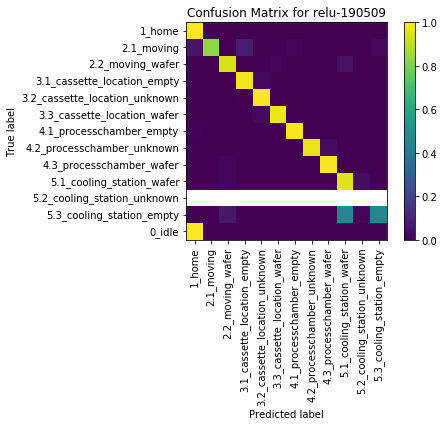

confusion matrix saved to ./output/ml\relu-190509.svg


In [16]:
np.set_printoptions(precision=3, threshold=1000, linewidth=180, nanstr="n", suppress=True)

# generate confusion matrix and normalize
confusion = confusion_matrix(confusion_labels, confusion_predictions)
pprint(confusion)
confusion = np.ma.array(confusion, mask=np.isnan(confusion))
confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# use all labels to allow for comparison
confusion_classes = [label_name[i][1] for i in label_name]

# discard columns from confusion matrix that are not known by model
index = 0
confusion_model_labels = []
confusion_model_columns = []
for label in label_name:
    if label not in model_labels:
        print("Label {} with index {} is not known to model. Dropping...".format(label_name[label], index))
    else:
        confusion_model_columns.append(index)
        confusion_model_labels.append(model_labels[label][1])
    index += 1
confusion = confusion[:,confusion_model_columns]
        
# setup plot
fig, ax = plt.subplots()
im = ax.imshow(confusion, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(confusion.shape[1]),
    yticks=np.arange(confusion.shape[0]),
    xticklabels=confusion_model_labels, yticklabels=confusion_classes,
    title="Confusion Matrix for {}".format(config_modelname),
    ylabel='True label',
    xlabel='Predicted label'
)
plt.setp(ax.get_yticklabels(), rotation_mode="anchor", ha="right", va="center")
plt.setp(ax.get_xticklabels(), rotation=90, rotation_mode="anchor", ha="right", va="center")

# save and show
svg_path = os.path.join(config["outputfolder"], "{}.svg".format(config_modelname))
plt.savefig(svg_path, format="svg", bbox_inches='tight')
plt.show()
print("confusion matrix saved to {}".format(svg_path))

In [6]:
if out is not None:
    out.release()
cv.destroyAllWindows()

In [7]:
# https://stackoverflow.com/questions/37657547/how-to-save-jupyter-notebook-to-html-by-code
from IPython.display import Javascript

def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"), include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import nbformat
    import codecs
    
    html_exporter = HTMLExporter()
    notebook = nbformat.read(read_file, as_version=4)
    body, resources = html_exporter.from_notebook_node(notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(body)
    
import time
save_notebook()
time.sleep(3)
current_file = "combined.ipynb"
output_file = os.path.join(config["outputfolder"], "{}.html".format(config_modelname))
output_HTML(current_file, output_file)

[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000] unknown (-1<>0)


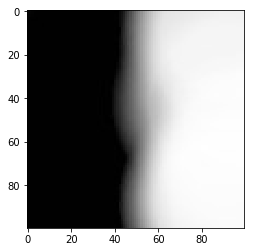

In [28]:
img = cv.imread(r"input\d.jpg", cv.IMREAD_GRAYSCALE)
mean, dev = cv.meanStdDev(img)
img_small = cv.resize((img - mean)/dev, (100,100))
img_small = np.expand_dims(img_small, axis=2)
img_small = np.expand_dims(img_small, axis=0)

predictions = model.predict(img_small)
predicted = np.argmax(predictions)
res = pprint_result(predictions[0], -1)

img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
plt.imshow(img); plt.show()
